In [1]:
#Import models to use
!pip install efficientnet --quiet
#!pip install --quiet kerasapplications


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import math, re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from functools import partial
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.experimental import CosineDecay


print("Tensorflow version " + tf.__version__)

import efficientnet.keras as efn



Tensorflow version 2.2.0


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()

VERSION = 5

SEED = 123

REPLICAS = strategy.num_replicas_in_sync

BATCH_SIZE = 16 * REPLICAS
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 100
LR = 0.01
MIN_LR = 1e-6

In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.2, random_state=5
)

#TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec')

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')

In [7]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label

In [8]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [9]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [10]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [11]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [12]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 16045 training images, 5352 validation images, 1 (unlabeled) test images


In [13]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [2 4 3 3 1 3 3 3 3 3 3 3 4 1 3 1 2 2 3 2 3 0 3 4 0 3 3 1 3 0 3 3 3 3 3 3 4
 4 1 3 0 3 3 2 1 3 3 4 2 3 3 2 4 3 3 0 3 3 3 3 1 3 3 3 0 1 3 3 1 3 4 3 3 0
 4 3 3 3 1 3 3 4 3 0 3 0 1 1 1 3 1 2 3 3 1 3 3 3 3 1 3 3 3 3 3 3 4 0 3 3 3
 4 1 3 1 2 4 0 3 3 3 4 3 3 0 3 3 2]
Validation data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data label examples: [3 3 3 1 3 3 3 3 4 0 4 3 0 2 4 3 3 3 3 1 3 3 2 3 3 3 1 2 3 3 1 3 0 3 3 1 3
 4 3 3 3 3 4 4 2 3 2 2 3 3 2 3 3 1 1 3 4 3 4 3 4 3 3 3 3 3 2 1 0 4 3 3 3 3
 3 0 0 2 3 3 3 2 3 3 1 3 3 3 3 3 4 3 0 3 3 2 1 3 3 3 4 4 4 3 4 3 3 3 2 4 1
 3 4 3 4 3 2 0 1 3 3 2 2 3 3 2 3 0]
Test data shapes:
(1, 512, 512, 3) (1,)
Test data IDs: ['2216849948.jpg']


In [14]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_plant(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_plant(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [15]:
# load our training dataset for EDA
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

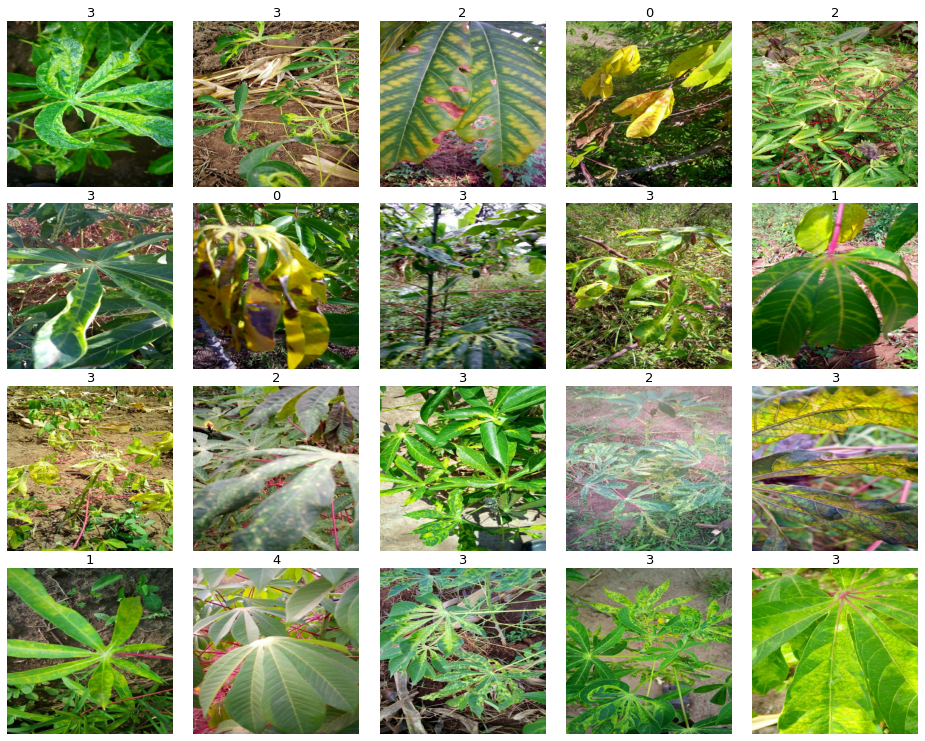

In [16]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(train_batch))

In [17]:
# load our validation dataset for EDA
validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch().batch(20)
valid_batch = iter(validation_dataset)

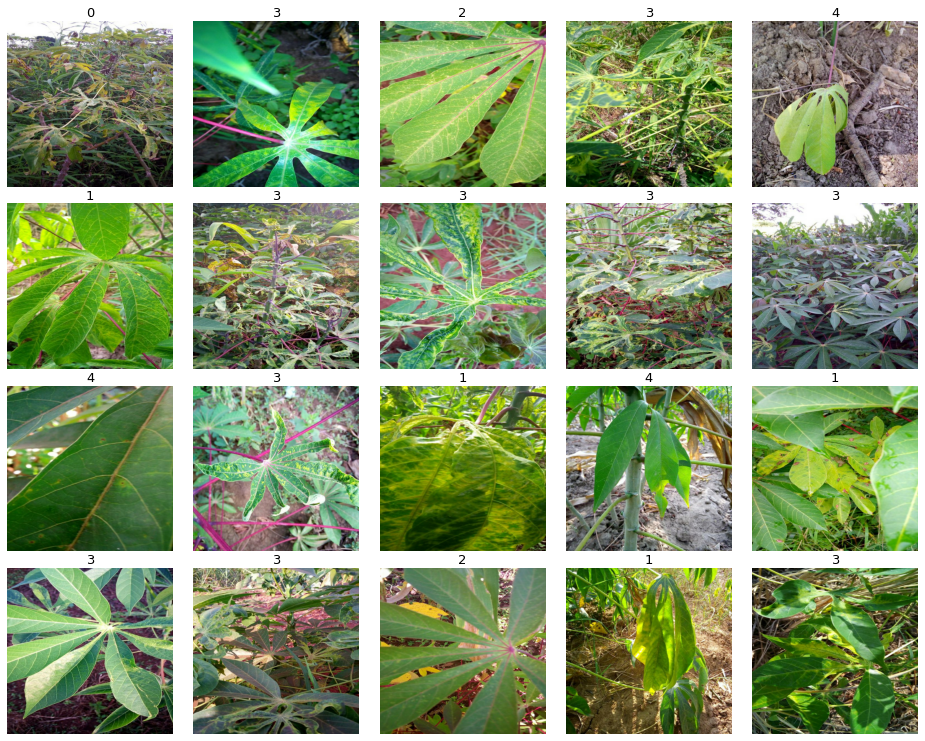

In [18]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(valid_batch))

In [19]:
# load our test dataset for EDA
testing_dataset = get_test_dataset()
testing_dataset = testing_dataset.unbatch().batch(20)
test_batch = iter(testing_dataset)

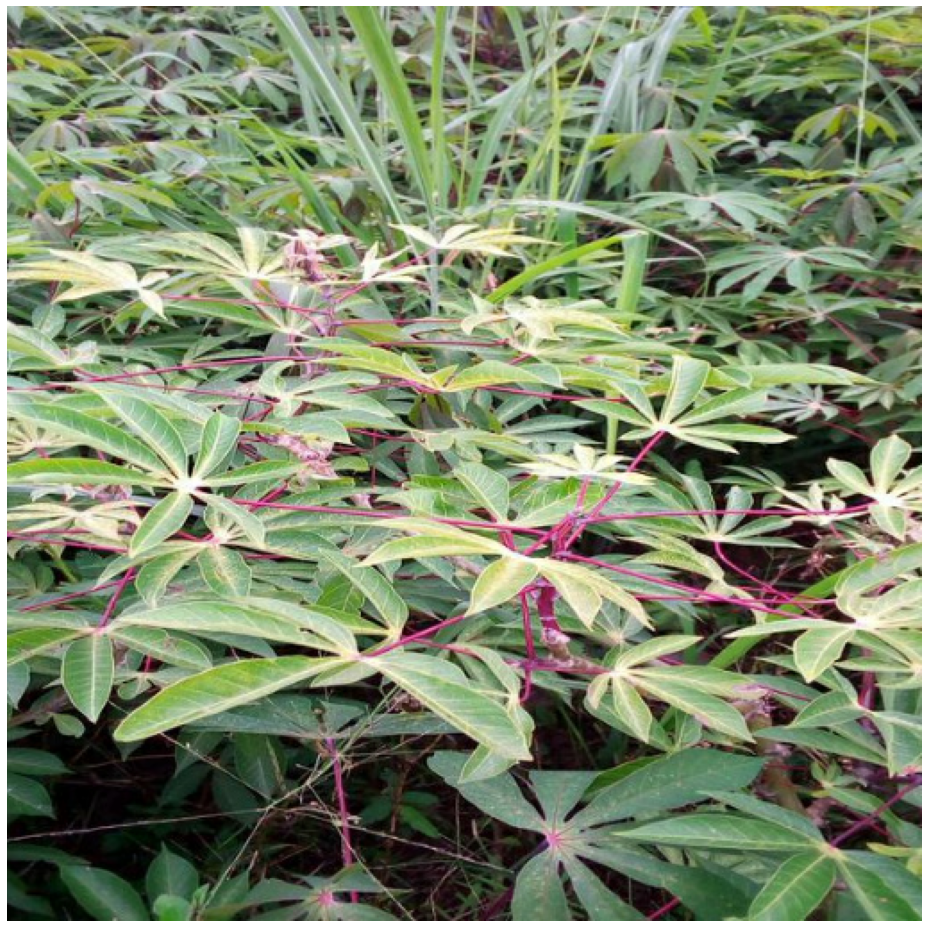

In [20]:
# we only have one test image
display_batch_of_images(next(test_batch))

In [21]:
lr_scheduler = keras.experimental.CosineDecayRestarts(
    initial_learning_rate=LR, 
    first_decay_steps=10000)


# lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
#                                               mode = 'max',
#                                               factor=0.5, 
#                                               patience=5, 
#                                               min_lr=0.1e-5, 
#                                               verbose=1)

In [22]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   patience=10, 
                                   restore_best_weights=True, 
                                   min_delta=0.0001,
                                   verbose=1)

In [23]:
with strategy.scope():       
    #img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, input_shape=[*IMAGE_SIZE, 3])
    #base_model = tf.keras.applications.EfficientNetB5(weights='imagenet', include_top=False)
    #base_model.trainable = False
    base_model = efn.EfficientNetB5(input_shape=[*IMAGE_SIZE, 3], include_top=False, weights='noisy-student')
    for layer in base_model.layers:
        layer.trainable = False
    
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(renorm=True),
        #img_adjust_layer,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation='relu'),
        #tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')  
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=lr_scheduler),
        loss='sparse_categorical_crossentropy',  
        metrics=['accuracy']
    )

115261440/115255328 [==============================] - 4s 0us/step


In [24]:
# if __name__ == '__main__':
#      # for training only, need nightly build pytorch

#     #seed_everything(CFG['seed'])
    
#     folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED).split(np.arange(NUM_TRAINING_IMAGES, train.label.values)
    
#     for fold, (trn_idx, val_idx) in enumerate(folds):
#         # we'll train fold 0 first
#         if fold > 0:
#             break 

#         print('Training with {} started'.format(fold))

#         print(len(trn_idx), len(val_idx))
#         train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/')

#         device = torch.device(CFG['device'])
        
#         model = CassvaImgClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
#         scaler = GradScaler()   
#         optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
#         #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
#         #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
#         #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        
#         loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
#         loss_fn = nn.CrossEntropyLoss().to(device)
        
#         for epoch in range(CFG['epochs']):
#             train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

#             with torch.no_grad():
#                 valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

#             torch.save(model.state_dict(),'{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
            
#         #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
#         del model, optimizer, train_loader, val_loader, scaler, scheduler
#         torch.cuda.empty_cache()

In [25]:
# load data
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [26]:
# for images, labels in train_dataset.take(1):  # only take first element of dataset
#     #numpy_images = images.numpy()
#     numpy_labels = labels.values

In [27]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS,
                    callbacks=[es]
                   )

Epoch 1/100
125/125 [==============================] - 74s 589ms/step - accuracy: 0.6015 - loss: 1.1463 - val_accuracy: 0.6231 - val_loss: 1.0013
Epoch 2/100
125/125 [==============================] - 49s 394ms/step - accuracy: 0.6357 - loss: 0.9522 - val_accuracy: 0.6486 - val_loss: 0.9050
Epoch 3/100
125/125 [==============================] - 49s 394ms/step - accuracy: 0.6503 - loss: 0.8923 - val_accuracy: 0.6721 - val_loss: 0.8534
Epoch 4/100
125/125 [==============================] - 49s 394ms/step - accuracy: 0.6741 - loss: 0.8461 - val_accuracy: 0.6883 - val_loss: 0.8164
Epoch 5/100
125/125 [==============================] - 49s 395ms/step - accuracy: 0.6836 - loss: 0.8201 - val_accuracy: 0.7014 - val_loss: 0.7884
Epoch 6/100
125/125 [==============================] - 49s 394ms/step - accuracy: 0.6945 - loss: 0.7995 - val_accuracy: 0.7142 - val_loss: 0.7659
Epoch 7/100
125/125 [==============================] - 50s 396ms/step - accuracy: 0.7052 - loss: 0.7763 - val_accuracy: 0.72

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  21        
_________________________________________________________________
efficientnet-b5 (Model)      (None, 16, 16, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  16392     
_________________________________________________________________
dense_1 (Dense)              multiple                  45        
Total params: 28,529,978
Trainable params: 16,443
Non-trainable params: 28,513,535
_________________________________________________________________


In [29]:
# print out variables available to us
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


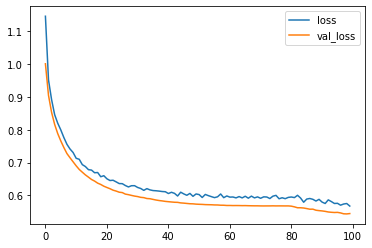

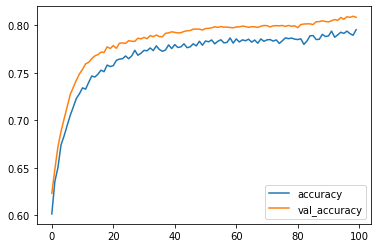

In [30]:
# create learning curves to evaluate model performance
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [31]:
model.save(f'new-effnetb5-v{VERSION}.h5')